In [26]:
import pandas as pd

# 파일 경로
file1 = 'df_merged_solar.csv'
file2 = 'df_merged_solar2.csv'

# 데이터 불러오기
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# 데이터 결합
df_merged = pd.concat([df1, df2], ignore_index=True)

# 결과 저장 (선택)
df_merged.to_csv('df_merged_solar+solar2.csv', index=False)
df_merged = df_merged[df_merged['발전구분'] != '(군산)영암F1태양광']

# 결합된 데이터 확인
print(df_merged.shape)
print(df_merged.head())
# "발전구분"이 "(군산)영암F1태양광"인 행 제거




(196890, 15)
             일자        발전구분  설비용량(MW)  시간  발전량(kWh)  연식(년)  지점명  기온(°C)  \
365  2023-01-01  (군산)삼랑진태양광       2.0   1       0.0   14.8  양산시     1.9   
366  2023-01-02  (군산)삼랑진태양광       2.0   1       0.0   14.8  양산시     3.2   
367  2023-01-03  (군산)삼랑진태양광       2.0   1       0.0   14.8  양산시     1.8   
368  2023-01-04  (군산)삼랑진태양광       2.0   1       0.0   14.8  양산시     0.7   
369  2023-01-05  (군산)삼랑진태양광       2.0   1       0.0   14.8  양산시    -1.1   

     강수량(mm)  풍속(m/s)  풍향(16방위)  습도(%)  일사(MJ/m2)  적설(cm)  하늘상태  
365      0.0      2.4     180.0   54.0        0.0     0.0   1.0  
366      0.0      1.7     320.0   32.0        0.0     0.0   4.0  
367      0.0      3.7     270.0   25.0        0.0     0.0   1.0  
368      0.0      2.8     290.0   37.0        0.0     0.0   1.0  
369      0.0      0.0       0.0   66.0        0.0     0.0   1.0  


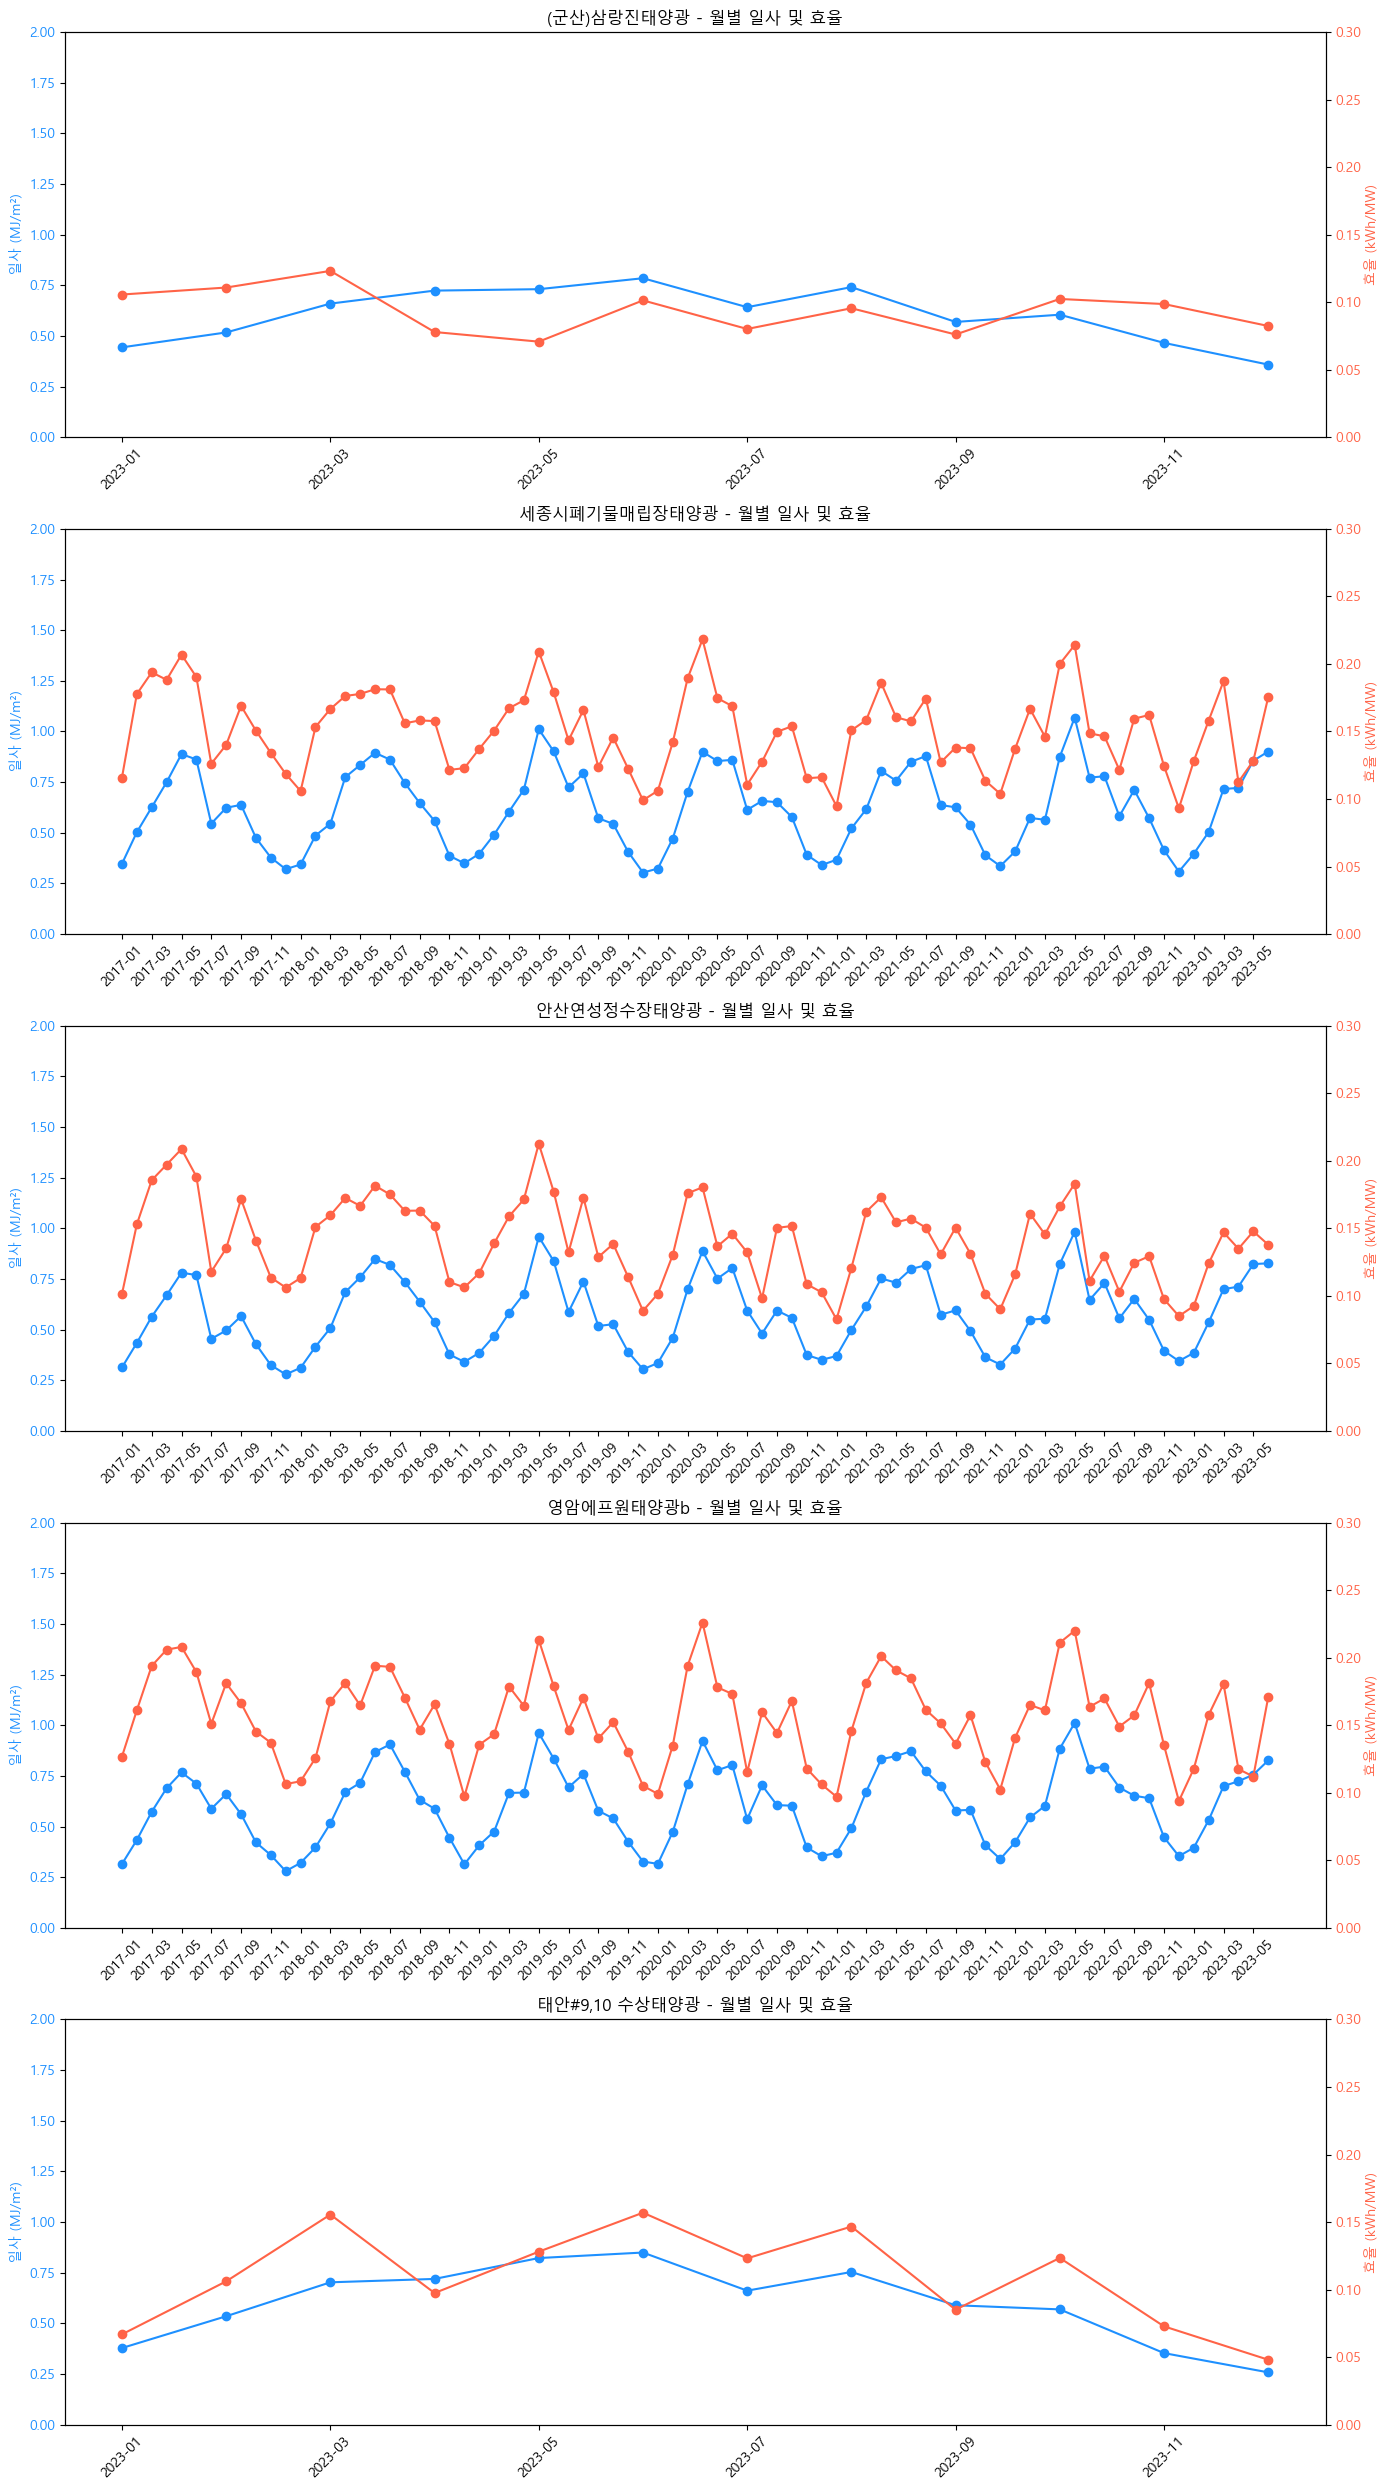

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ✅ 사용자 설정 y축 범위
irr_min, irr_max = 0, 2   # 일사 (MJ/m²)
eff_min, eff_max = 0, 0.3      # 효율 (kWh/MW)

# ✅ 연월 및 효율 계산
df_merged['일자'] = pd.to_datetime(df_merged['일자'], errors='coerce')
df_merged['연월'] = df_merged['일자'].dt.to_period('M').astype(str)
df_merged['효율'] = df_merged['발전량(kWh)'] / (df_merged['설비용량(MW)'] * 1000)

# ✅ 결측 제거 및 월별 평균
df_cleaned = df_merged.dropna(subset=['연월', '발전구분', '일사(MJ/m2)', '효율'])
grouped = df_cleaned.groupby(['발전구분', '연월']).agg({
    '일사(MJ/m2)': 'mean',
    '효율': 'mean'
}).reset_index()

# ✅ 발전소 리스트
plants = grouped['발전구분'].unique()
num_plants = len(plants)

# ✅ 전체 Figure 생성 (세로로 나열)
fig, axes = plt.subplots(num_plants, 1, figsize=(14, 5 * num_plants))

if num_plants == 1:
    axes = [axes]  # subplot이 1개일 경우도 리스트로 처리

for i, plant in enumerate(plants):
    ax1 = axes[i]
    sub = grouped[grouped['발전구분'] == plant]
    x = sub['연월']

    # 일사 (왼쪽 y축)
    ax1.plot(x, sub['일사(MJ/m2)'], color='dodgerblue', marker='o', label='일사 (MJ/m²)')
    ax1.set_ylabel('일사 (MJ/m²)', color='dodgerblue')
    ax1.tick_params(axis='y', labelcolor='dodgerblue')
    ax1.set_ylim(irr_min, irr_max)

    # 효율 (오른쪽 y축)
    ax2 = ax1.twinx()
    ax2.plot(x, sub['효율'], color='tomato', marker='o', label='효율')
    ax2.set_ylabel('효율 (kWh/MW)', color='tomato')
    ax2.tick_params(axis='y', labelcolor='tomato')
    ax2.set_ylim(eff_min, eff_max)

    # x축 설정
    ax1.set_xticks(x[::2])
    ax1.set_xticklabels(x[::2], rotation=45)

    ax1.set_title(f'{plant} - 월별 일사 및 효율')

# ✅ 전체 레이아웃 조정 및 저장
plt.tight_layout()
plt.savefig('solar3_일사량-발전효율.png', dpi=300)
plt.show()

df_merged = df_merged.drop(columns=['효율', '연월'], errors='ignore')




In [41]:
print(df_merged['발전구분'].unique())


['(군산)삼랑진태양광' '태안#9,10 수상태양광' '세종시폐기물매립장태양광' '안산연성정수장태양광' '영암에프원태양광b']


In [42]:
import pandas as pd
import pvlib

# 1) 위도·경도 정보 (지점 기준) - 반드시 실제 위치 기반으로 업데이트 필요
location_info = {
    '(군산)삼랑진태양광': (35.3867, 128.8963),   # 경남 밀양시 삼랑진읍 부근
    '태안#9,10 수상태양광': (36.7868, 126.2987), # 충남 태안군 원북면 부근
    '세종시폐기물매립장태양광': (36.5287, 127.2875), # 세종시 연서면 일대
    '안산연성정수장태양광': (37.3219, 126.8337), # 경기도 안산시 단원구 부근
    '영암에프원태양광b': (34.7577, 126.3910),    # 전남 영암 F1 경기장 부근
}

# 2) 시간 형변환 및 24시 처리
df_merged['시간'] = df_merged['시간'].astype(int)
df_merged['시간조정'] = df_merged['시간'] % 24
df_merged['일자조정'] = pd.to_datetime(df_merged['일자']) + pd.to_timedelta((df_merged['시간'] // 24), unit='D')

# 3) '일시' 컬럼 생성 + 타임존 지정 (Asia/Seoul)
df_merged['일시'] = pd.to_datetime(
    df_merged['일자조정'].dt.strftime('%Y-%m-%d') + ' ' + df_merged['시간조정'].astype(str) + ':00:00'
)
df_merged['일시'] = df_merged['일시'].dt.tz_localize('Asia/Seoul')

# 4) 태양 위치 계산 함수
def compute_solar_pos(row):
    plant = row['발전구분']
    dt = row['일시']
    if plant not in location_info:
        return pd.Series([None, None])
    lat, lon = location_info[plant]
    loc = pvlib.location.Location(lat, lon, tz='Asia/Seoul')
    pos = loc.get_solarposition(times=[dt])
    return pd.Series([pos['apparent_elevation'].iloc[0], pos['azimuth'].iloc[0]])

# 5) 계산 적용
df_merged[['태양고도', '방위각']] = df_merged.apply(compute_solar_pos, axis=1)

# 6) 고도가 0 이하인 경우 방위각 결측 처리
df_merged.loc[df_merged['태양고도'] <= 0, '방위각'] = None

# 7) 시간대별 평균 고도 계산 (정상 확인용)
summary_hour = df_merged.groupby(df_merged['일시'].dt.hour)['태양고도'].mean().reset_index()
summary_hour.columns = ['시간대', '평균 고도 (°)']
print(summary_hour)

# 저장 원할 경우 주석 해제
# summary_hour.to_csv('평균_고도_시간대별.csv', index=False)


    시간대  평균 고도 (°)
0     0 -52.376859
1     1 -52.541341
2     2 -47.309988
3     3 -38.885498
4     4 -28.728949
5     5 -17.621692
6     6  -5.949295
7     7   5.810431
8     8  17.453927
9     9  28.615963
10   10  38.943151
11   11  47.665510
12   12  53.371226
13   13  53.659422
14   14  48.306516
15   15  39.743708
16   16  29.492814
17   17  18.362257
18   18   6.731319
19   19  -5.040757
20   20 -16.746459
21   21 -27.918338
22   22 -38.185471
23   23 -46.794930


In [46]:
df_merged = df_merged.drop(columns=[
    '시간조정', '일자조정', '일시', 'sun_elevation', 'sun_azimuth', 'hour'
], errors='ignore')
df_merged.tail(40)

,일자,발전구분,설비용량(MW),시간,발전량(kWh),연식(년),지점명,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),일사(MJ/m2),적설(cm),하늘상태,태양고도,방위각
205610,2023-06-17,영암에프원태양광b,13.296,24,0.0,10.5,목포,21.3,0.0,0.0,0.0,86.0,0.0,0.0,4.0,-31.258734,NaN
205611,2023-06-18,세종시폐기물매립장태양광,1.628,24,0.0,11.0,청주,24.7,0.0,0.7,250.0,53.0,0.0,0.0,1.0,-29.592171,NaN
205612,2023-06-18,안산연성정수장태양광,1.490,24,0.0,10.9,수원,20.9,0.0,0.9,230.0,74.0,0.0,0.0,1.0,-28.753463,NaN
205613,2023-06-18,영암에프원태양광b,13.296,24,0.0,10.5,목포,20.5,0.0,2.0,320.0,89.0,0.0,0.0,1.0,-31.227414,NaN
205614,2023-06-19,세종시폐기물매립장태양광,1.628,24,0.0,11.0,청주,26.8,0.0,1.3,140.0,47.0,0.0,0.0,3.0,-29.568566,NaN
205615,2023-06-19,안산연성정수장태양광,1.490,24,0.0,10.9,수원,23.0,0.0,0.9,250.0,71.0,0.0,0.0,3.0,-28.729630,NaN
205616,2023-06-19,영암에프원태양광b,13.296,24,0.0,10.5,목포,22.6,0.0,0.0,0.0,73.0,0.0,0.0,3.0,-31.202851,NaN
205617,2023-06-20,세종시폐기물매립장태양광,1.628,24,0.0,11.0,청주,20.7,0.2,2.1,50.0,84.0,0.0,0.0,4.0,-29.551758,NaN
205618,2023-06-20,안산연성정수장태양광,1.490,24,0.0,10.9,수원,19.4,14.5,1.6,70.0,96.0,0.0,0.0,4.0,-28.712591,NaN
205619,2023-06-20,영암에프원태양광b,13.296,24,0.0,10.5,목포,21.9,0.1,4.8,140.0,94.0,0.0,0.0,4.0,-31.185063,NaN


In [51]:
import numpy as np

df_merged.loc[df_merged['태양고도'] < 0, '태양고도'] = 0
df_merged.loc[df_merged['태양고도'] <= 0, '방위각'] = np.nan

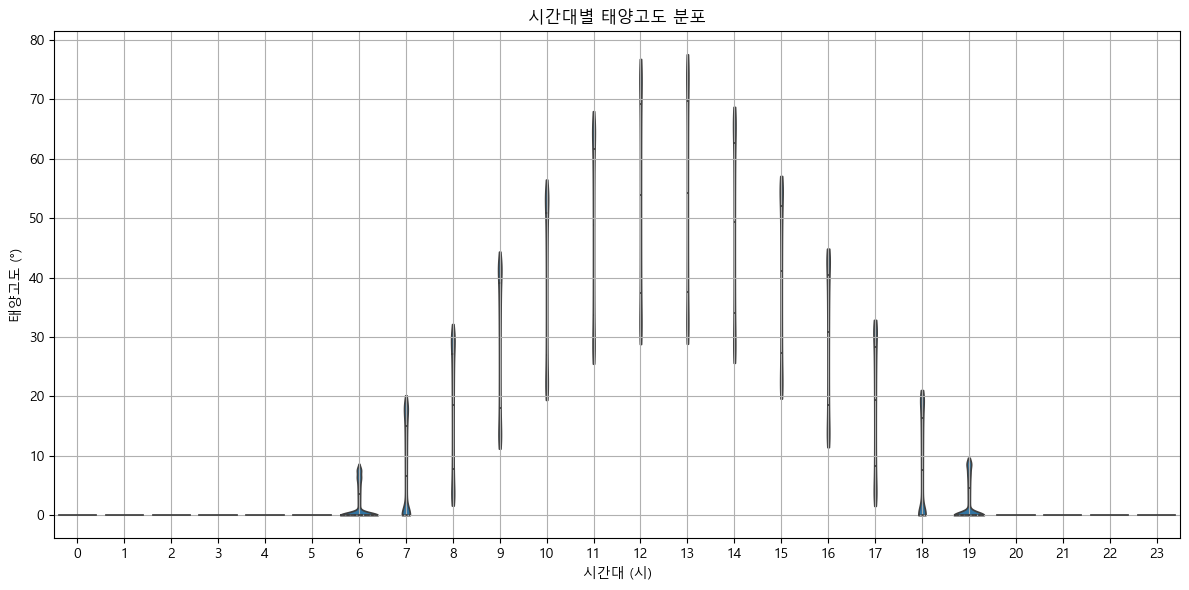

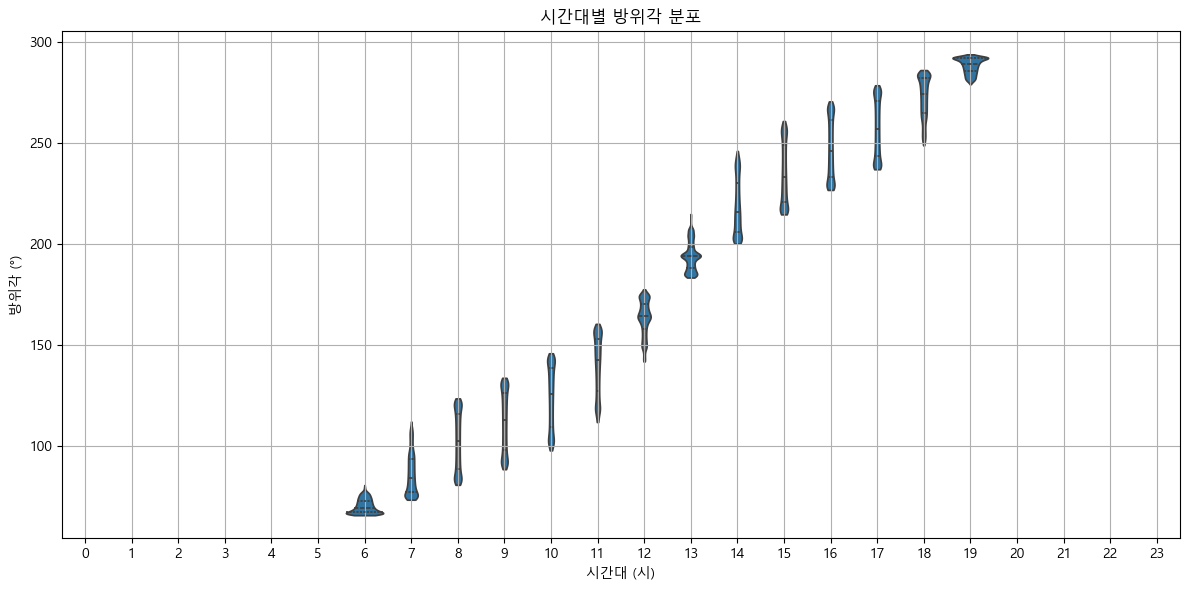

In [52]:
# 시간대 컬럼을 생성 (기존 '시간'을 그대로 복사해서 사용)
df_merged['시간대'] = df_merged['시간'] % 24  # 혹시 24가 섞여 있으면 0시로 바꿔줌

# 1. 태양고도 분포 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12, 6))
sns.violinplot(data=df_merged, x='시간대', y='태양고도', inner='quartile', cut=0)
plt.title('시간대별 태양고도 분포')
plt.xlabel('시간대 (시)')
plt.ylabel('태양고도 (°)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. 방위각 분포 시각화
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_merged, x='시간대', y='방위각', inner='quartile', cut=0)
plt.title('시간대별 방위각 분포')
plt.xlabel('시간대 (시)')
plt.ylabel('방위각 (°)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. 임시 컬럼 삭제
df_merged.drop(columns=['시간대'], inplace=True)


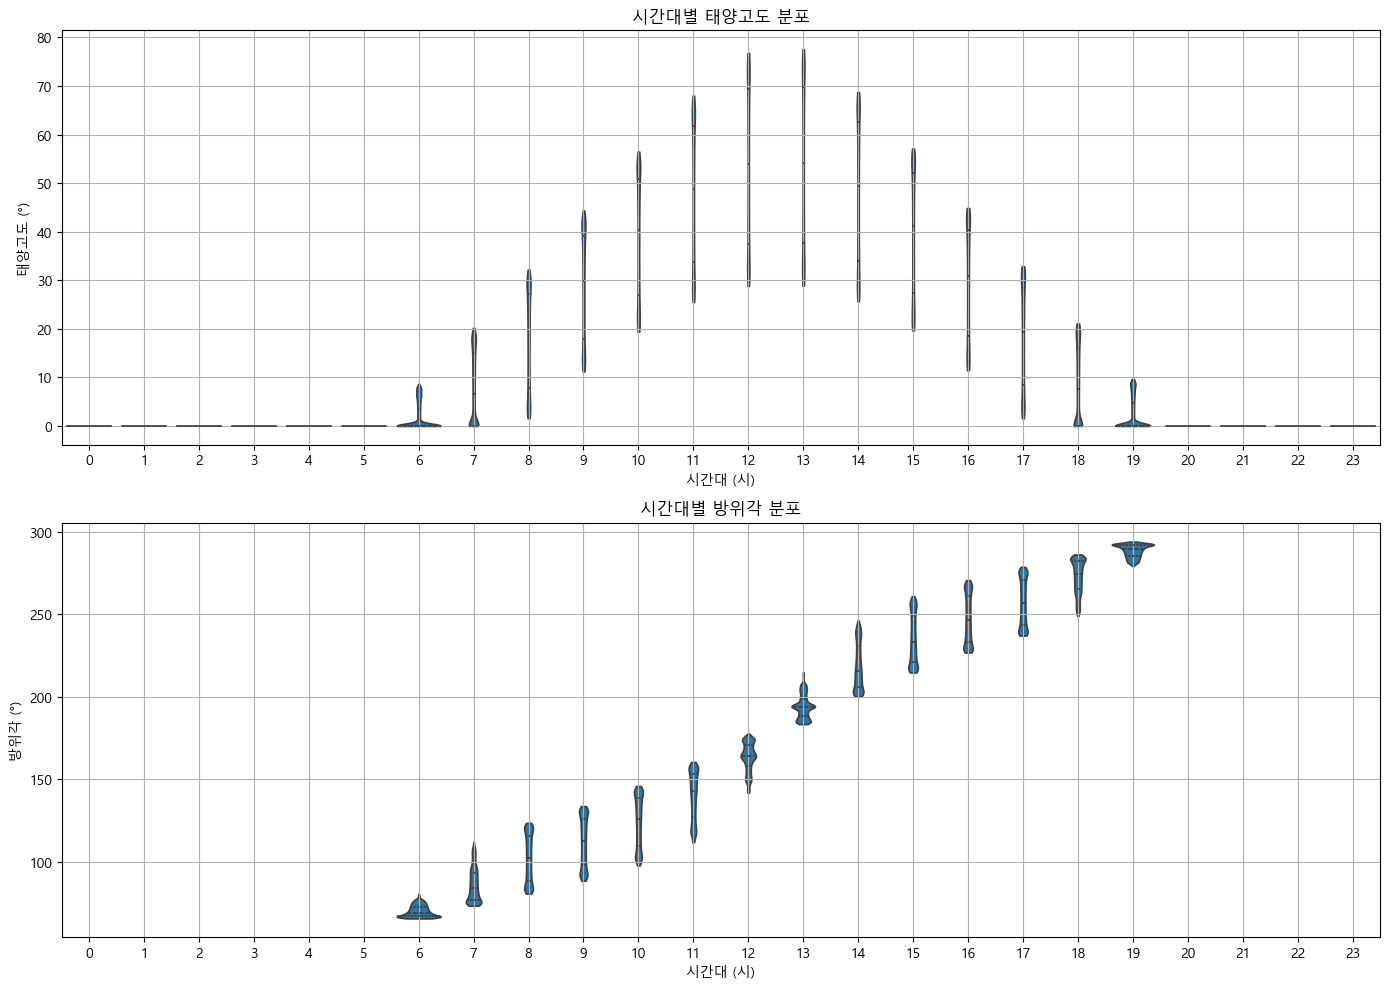

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 시간대 컬럼 생성 (시간을 0~23시로 정규화)
df_merged['시간대'] = df_merged['시간'] % 24

# 2. 그래프 생성 및 저장
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10))

# (1) 태양고도 분포
sns.violinplot(data=df_merged, x='시간대', y='태양고도', inner='quartile', cut=0, ax=axes[0])
axes[0].set_title('시간대별 태양고도 분포')
axes[0].set_xlabel('시간대 (시)')
axes[0].set_ylabel('태양고도 (°)')
axes[0].grid(True)

# (2) 방위각 분포
sns.violinplot(data=df_merged, x='시간대', y='방위각', inner='quartile', cut=0, ax=axes[1])
axes[1].set_title('시간대별 방위각 분포')
axes[1].set_xlabel('시간대 (시)')
axes[1].set_ylabel('방위각 (°)')
axes[1].grid(True)

plt.tight_layout()
plt.savefig('태양고도_방위각_분포.png', dpi=300)  # 🔽 여기서 저장됨
plt.show()

# 3. 임시 컬럼 삭제
df_merged.drop(columns=['시간대'], inplace=True)


In [56]:
df_merged = df_merged.sort_values(by=['일자', '시간']).reset_index(drop=True)


In [57]:
df_merged

,일자,발전구분,설비용량(MW),시간,발전량(kWh),연식(년),지점명,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),일사(MJ/m2),적설(cm),하늘상태,태양고도,방위각
0,2017-01-01,세종시폐기물매립장태양광,1.628,1,0.0,4.6,청주,2.2,0.0,0.2,0.0,78.0,0.0,0.0,NaN,0.0,NaN
1,2017-01-01,안산연성정수장태양광,1.490,1,0.0,4.4,수원,0.1,0.0,0.3,0.0,96.0,0.0,0.0,NaN,0.0,NaN
2,2017-01-01,영암에프원태양광b,13.296,1,0.0,4.1,목포,5.0,0.0,1.8,160.0,93.0,0.0,0.0,NaN,0.0,NaN
3,2017-01-01,세종시폐기물매립장태양광,1.628,2,0.0,4.6,청주,1.9,0.0,0.5,340.0,80.0,0.0,0.0,NaN,0.0,NaN
4,2017-01-01,안산연성정수장태양광,1.490,2,0.0,4.4,수원,-1.1,0.0,0.0,0.0,97.0,0.0,0.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196885,2023-12-31,(군산)삼랑진태양광,2.000,23,0.0,15.7,양산시,2.3,0.0,0.6,160.0,85.0,0.0,0.0,1.0,0.0,NaN
196886,2023-12-31,"태안#9,10 수상태양광",1.836,23,0.0,7.7,서산,2.8,0.0,0.3,0.0,91.0,0.0,0.0,4.0,0.0,NaN
196887,2023-12-31,(군산)삼랑진태양광,2.000,24,0.0,15.7,양산시,2.4,0.0,1.0,110.0,87.0,0.0,0.0,1.0,0.0,NaN
196888,2023-12-31,(군산)삼랑진태양광,2.000,24,0.0,15.7,양산시,2.4,0.0,1.0,110.0,87.0,0.0,0.0,1.0,0.0,NaN


In [58]:
df_merged.to_csv('df_merged_solar_final.csv', index=False, encoding='utf-8-sig')
